<a href="https://colab.research.google.com/github/utkarsh9630/AI4Invest-Collab/blob/main/Meeting_Summarizer_Proto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meeting Summarizer: Extended Dataset + LoRA Fine-tuning (RTX 4090 Optimized)

## Cell 1: Installation

In [1]:
'''
!pip uninstall -y transformers
!pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
!pip install -q transformers==4.41.0
!pip install -q peft==0.7.1 bitsandbytes==0.43.3 accelerate datasets trl scipy
print("Installation complete")
'''

'\n!pip uninstall -y transformers\n!pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121\n!pip install -q transformers==4.41.0\n!pip install -q peft==0.7.1 bitsandbytes==0.43.3 accelerate datasets trl scipy\n!pip install -q rouge-score nltk tqdm scikit-learn matplotlib seaborn pandas\n!pip install -q icalendar python-dateutil dateparser\nprint("Installation complete")\n'

In [2]:
'''
!pip install -q rouge-score nltk tqdm scikit-learn matplotlib seaborn pandas
!pip install -q icalendar python-dateutil dateparser
'''

'\n!pip install -q rouge-score nltk tqdm scikit-learn matplotlib seaborn pandas\n!pip install -q icalendar python-dateutil dateparser\n'

## Cell 2: Imports and Setup

In [3]:

import os
import json
import math
import re
import random
import time
import gc
import warnings
import csv
from dataclasses import dataclass
from typing import List, Dict, Optional, Any
from datetime import datetime, timedelta

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, concatenate_datasets, Dataset
from tqdm.auto import tqdm

import nltk
nltk.download('punkt', quiet=True)
try:
    nltk.download('punkt_tab', quiet=True)
except:
    pass
from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training,
)

try:
    from icalendar import Calendar, Event, vText, Alarm
    import dateparser
    ICS_AVAILABLE = True
except ImportError:
    ICS_AVAILABLE = False
    print("Warning: icalendar not available")

warnings.filterwarnings('ignore')

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

print(f"Torch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Compute capability: {torch.cuda.get_device_capability(0)}")

Torch: 2.2.2+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4090
VRAM: 24.0 GB
Compute capability: (8, 9)


## Cell 3: Hugging Face Login

In [4]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
from getpass import getpass
from huggingface_hub import login, whoami, notebook_login, HfFolder

def _colab_secret(name: str):
    try:
        from google.colab import userdata
        return userdata.get(name)
    except Exception:
        return None

# Try to get the token from several places first
token = (
    os.getenv("HF_TOKEN")
    or _colab_secret("HF_TOKEN")
    or HfFolder.get_token()
)

# If no token found, ask the user at runtime
if not token:
    print("No Hugging Face token found in environment, Colab userdata, or HfFolder.")
    token = getpass("Please enter your Hugging Face token (or leave blank to use notebook_login): ").strip()

if token:
    try:
        login(token=token, add_to_git_credential=True)
        me = whoami()
        print(f"Logged in as: {me.get('name') or me.get('email')}")
    except Exception as e:
        print(f"Token login failed with error: {e}")
        print("Falling back to notebook_login()...")
        notebook_login()
else:
    # User pressed enter without providing a token → use notebook widget
    notebook_login()


Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Logged in as: utkarsh9630


## Cell 4: Configuration (4090 Optimized)

In [6]:
@dataclass
class Config:
    DATASET_REPO = "knkarthick/AMI"
    TOTAL_SAMPLES = 279
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    RANDOM_STATE = 42
    BASE_MODEL = "google/flan-t5-large"
    LORA_R = 32
    LORA_ALPHA = 64
    LORA_DROPOUT = 0.1
    LORA_TARGET_MODULES = ["q", "v", "k", "o", "wi", "wo"]
    USE_QLORA = False
    NUM_EPOCHS = 8
    BATCH_SIZE = 4
    GRADIENT_ACCUMULATION = 4
    LEARNING_RATE = 5e-5
    MAX_SOURCE_LENGTH = 1024
    MAX_TARGET_LENGTH = 512
    WARMUP_STEPS = 50
    USE_COT = True
    USE_FEW_SHOT = True
    GEN_MAX_LENGTH = 512
    GEN_MIN_LENGTH = 100
    NUM_BEAMS = 4
    WTS = {"coherence": 0.20, "consistency": 0.30, "fluency": 0.15, "relevance": 0.20, "action_quality": 0.15}
    OUTPUT_DIR = "final_prototype_ami"
    MODEL_SAVE_DIR = "final_model_ami"

cfg = Config()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.makedirs(cfg.MODEL_SAVE_DIR, exist_ok=True)
print(f"Dataset: {cfg.DATASET_REPO}, Samples: {cfg.TOTAL_SAMPLES}, Epochs: {cfg.NUM_EPOCHS}, LR: {cfg.LEARNING_RATE}")


Dataset: knkarthick/AMI, Samples: 279, Epochs: 8, LR: 5e-05


## Cell 5: Load Extended Dataset

In [7]:
print("Loading AMI dataset...")
ds = load_dataset("knkarthick/AMI")
print("Loaded")
for s, d in ds.items():
    print(f"  {s}: {len(d)}")
combined = concatenate_datasets([ds[s] for s in ['train', 'validation', 'test'] if s in ds])
print(f"Total: {len(combined)}")
pool = []
for idx, item in enumerate(tqdm(combined)):
    t = item.get('dialogue', '')
    s = item.get('summary', '')
    if isinstance(t, list): t = ' '.join(str(x) for x in t)
    if isinstance(s, list): s = ' '.join(str(x) for x in s)
    t, s = str(t).strip(), str(s).strip()
    if not t or not s or len(t.split()) < 100 or len(s.split()) < 20: continue
    pool.append({"transcript": t, "summary": s, "id": item.get('id', f"m_{idx}")})
print(f"Valid: {len(pool)}")
random.seed(cfg.RANDOM_STATE)
random.shuffle(pool)
n = len(pool)
n_train, n_val = int(n * 0.7), int(n * 0.15)
train_data = pool[:n_train]
val_data = pool[n_train:n_train+n_val]
test_data = pool[n_train+n_val:]
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Loading AMI dataset...
Loaded
  train: 209
  validation: 42
  test: 28
Total: 279


  0%|          | 0/279 [00:00<?, ?it/s]

Valid: 279
Train: 195, Val: 41, Test: 43


In [8]:
# Few-Shot Chain-of-Thought Prompts

FEW_SHOT_EXAMPLES = """Example 1:
Meeting: The team discussed the new product launch. Sarah will prepare the marketing deck by Friday. John needs to finalize the budget by next week. The next meeting is scheduled for Monday at 2 PM.

Summary:
Main Topic: New product launch planning
Key Discussion: Marketing strategy and budget allocation
Decisions Made: Marketing deck and budget to be finalized before next meeting

Action Items:
[Sarah] - Prepare marketing presentation deck - Due: Friday
[John] - Finalize product launch budget - Due: Next week

Next Meeting:
Date: Monday
Time: 2 PM
Purpose: Review marketing materials and budget

Example 2:
Meeting: The engineering team reviewed the API integration. Mike found a bug in the authentication module. Lisa will fix it by Wednesday. The team agreed to use OAuth 2.0. Testing phase starts next Monday.

Summary:
Main Topic: API integration review
Key Discussion: Authentication issues and security protocols
Decisions Made: Implement OAuth 2.0, start testing next Monday

Action Items:
[Lisa] - Fix authentication module bug - Due: Wednesday
[Mike] - Review security implementation - Due: Friday

Next Meeting:
Date: Next Monday
Time: 10 AM
Purpose: Begin testing phase
"""

def create_few_shot_cot_prompt(transcript):
    return f"""{FEW_SHOT_EXAMPLES}

Now analyze this meeting transcript following the same format:

Meeting: {transcript}

Provide a structured summary with:
- Main Topic
- Key Discussion points
- Decisions Made
- Action Items in format: [Owner] - Task - Due: Deadline
- Next Meeting (if mentioned)

Summary:
"""

def create_cot_prompt(transcript):
    return f"""Analyze this meeting step by step:

1. What were the main topics discussed?
2. What key decisions were made?
3. What action items were assigned (who, what, when)?
4. Is there a follow-up meeting scheduled?

Meeting Transcript:
{transcript}

Analysis:
"""

print("Few-shot Chain-of-Thought prompting enabled")
print("Template includes 2 example meetings with action items")


Few-shot Chain-of-Thought prompting enabled
Template includes 2 example meetings with action items


## Cell 6: Chain-of-Thought Prompt Engineering

In [9]:
COT_PROMPT_TEMPLATE = """You are an expert meeting summarizer. Follow these reasoning steps:

Step 1: Scan the transcript and identify all speakers and their main contributions.
Step 2: Extract the primary topics and key discussion points.
Step 3: Identify concrete decisions that were made and who made them.
Step 4: List all action items with clear owners and deadlines.
Step 5: Determine if follow-up meetings or communications are needed.
Step 6: Synthesize all information into a structured summary.

Generate a summary with exactly these sections:

1) Overview: 2-4 sentences covering meeting purpose and outcomes
2) Key Points: 3-7 bullet points of main discussion topics
3) Decisions: Bullet points of concrete decisions or 'None'
4) Action Items: Format each as [Owner] - Task description - Due: <date or 'None'>
5) Next Meeting: Either 'Not scheduled' or 'Scheduled - Date: <date> - Time: <time> - Purpose: <purpose>'

Transcript:
{transcript}

Structured Summary:"""

STANDARD_PROMPT_TEMPLATE = """Generate a structured meeting summary with these sections:

1) Overview: 2-4 sentences
2) Key Points: 3-7 bullet points
3) Decisions: Bullet points or 'None'
4) Action Items: Format as [Owner] - Task - Due: <date or 'None'>
5) Next Meeting: 'Not scheduled' or 'Scheduled - Date: <date> - Time: <time> - Purpose: <purpose>'

Transcript:
{transcript}

Summary:"""

def build_prompt(transcript: str, use_cot: bool = True) -> str:
    template = COT_PROMPT_TEMPLATE if use_cot else STANDARD_PROMPT_TEMPLATE
    max_chars = cfg.MAX_SOURCE_LENGTH * 4
    return template.format(transcript=transcript.strip()[:max_chars])

print("CoT prompt templates defined")
sample_prompt = build_prompt(train_data[0]["transcript"], use_cot=True)
print(f"Sample prompt length: {len(sample_prompt)} chars")

CoT prompt templates defined
Sample prompt length: 5033 chars


## Cell 7: Prepare Dataset for Training

In [10]:
from datasets import Dataset

def prepare_training_data(data_list, tokenizer, use_cot=True):
    inputs = []
    targets = []

    for item in data_list:
        prompt = build_prompt(item["transcript"], use_cot=use_cot)
        inputs.append(prompt)
        targets.append(item["summary"])

    model_inputs = tokenizer(
        inputs,
        max_length=cfg.MAX_SOURCE_LENGTH,
        truncation=True,
        padding=False,
    )

    labels = tokenizer(
        targets,
        max_length=cfg.MAX_TARGET_LENGTH,
        truncation=True,
        padding=False,
    )

    model_inputs["labels"] = labels["input_ids"]
    return Dataset.from_dict(model_inputs)

print("Data preparation function defined")

Data preparation function defined


## Cell 8: Setup LoRA Configuration (4090 Optimized)

In [11]:
print("Loading tokenizer and base model...")

tokenizer = AutoTokenizer.from_pretrained(cfg.BASE_MODEL, use_fast=True)

if cfg.USE_QLORA:
    from transformers import BitsAndBytesConfig

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )

    model = AutoModelForSeq2SeqLM.from_pretrained(
        cfg.BASE_MODEL,
        quantization_config=bnb_config,
        device_map="auto",
    )
    model = prepare_model_for_kbit_training(model)
    print("Model loaded with QLoRA (4-bit)")
else:
    model = AutoModelForSeq2SeqLM.from_pretrained(
        cfg.BASE_MODEL,
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )
    print("Model loaded in bfloat16 (full precision for 4090)")

lora_config = LoraConfig(
    r=cfg.LORA_R,
    lora_alpha=cfg.LORA_ALPHA,
    target_modules=cfg.LORA_TARGET_MODULES,
    lora_dropout=cfg.LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)

model = get_peft_model(model, lora_config)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"LoRA configuration:")
print(f"  Rank: {cfg.LORA_R}")
print(f"  Alpha: {cfg.LORA_ALPHA}")
print(f"  Target modules: {cfg.LORA_TARGET_MODULES}")
print(f"  Dropout: {cfg.LORA_DROPOUT}")
print(f"Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.3f}%)")
print(f"Total params: {total_params:,}")

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"GPU memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

try:
    from icalendar import Calendar, Event, vText, Alarm
    import dateparser
    ICS_AVAILABLE = True
except ImportError:
    ICS_AVAILABLE = False
    print("Warning: icalendar not available")


Loading tokenizer and base model...


`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded in bfloat16 (full precision for 4090)
LoRA configuration:
  Rank: 32
  Alpha: 64
  Target modules: ['q', 'v', 'k', 'o', 'wi', 'wo']
  Dropout: 0.1
Trainable params: 24,772,608 (3.066%)
Total params: 807,922,688
GPU memory: 1.54GB allocated, 1.71GB reserved


## Cell 9: Prepare Training Datasets

In [12]:
print("Preparing training datasets...")

train_dataset = prepare_training_data(train_data, tokenizer, use_cot=cfg.USE_COT)
val_dataset = prepare_training_data(val_data, tokenizer, use_cot=cfg.USE_COT)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Sample input tokens: {len(train_dataset[0]['input_ids'])}")
print(f"Sample label tokens: {len(train_dataset[0]['labels'])}")

Preparing training datasets...
Train dataset: 195 samples
Val dataset: 41 samples
Sample input tokens: 1024
Sample label tokens: 512


## Cell 10: Training Configuration and Fine-tuning

In [13]:
training_args = TrainingArguments(
    output_dir=cfg.MODEL_SAVE_DIR,
    num_train_epochs=cfg.NUM_EPOCHS,
    per_device_train_batch_size=cfg.BATCH_SIZE,
    per_device_eval_batch_size=cfg.BATCH_SIZE,
    gradient_accumulation_steps=cfg.GRADIENT_ACCUMULATION,
    learning_rate=cfg.LEARNING_RATE,
    weight_decay=0.01,
    warmup_ratio=0.1,  # Increased
    lr_scheduler_type="linear",  # Changed
    logging_steps=25,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=False,
    bf16=True,
    tf32=True,
    optim="adamw_torch_fused",
    gradient_checkpointing=True,  # ENABLE for memory
    dataloader_num_workers=0,  # Disabled
    dataloader_pin_memory=False,  # Disabled
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
)

# Ensure model is in training mode
model.train()

# Enable input gradients for LoRA
if hasattr(model, 'enable_input_require_grads'):
    model.enable_input_require_grads()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

total_steps = len(train_dataset) // (cfg.BATCH_SIZE * cfg.GRADIENT_ACCUMULATION) * cfg.NUM_EPOCHS
print(f"Training configuration:")
print(f"  Epochs: {cfg.NUM_EPOCHS}")
print(f"  Batch size per device: {cfg.BATCH_SIZE}")
print(f"  Gradient accumulation: {cfg.GRADIENT_ACCUMULATION}")
print(f"  Effective batch size: {cfg.BATCH_SIZE * cfg.GRADIENT_ACCUMULATION}")
print(f"  Learning rate: {cfg.LEARNING_RATE}")
print(f"  Total optimization steps: {total_steps}")
print(f"  Warmup steps: {int(total_steps * 0.05)}")
print(f"  Gradient checkpointing: False (disabled for LoRA stability)")

print("\nStarting fine-tuning...")
start_time = time.time()
train_result = trainer.train()
training_time = time.time() - start_time

print(f"\nTraining complete")
print(f"Train loss: {train_result.training_loss:.4f}")
print(f"Training time: {training_time:.1f}s ({training_time/60:.1f} min)")
print(f"Samples per second: {len(train_dataset) * cfg.NUM_EPOCHS / training_time:.1f}")

trainer.save_model()
tokenizer.save_pretrained(cfg.MODEL_SAVE_DIR)
print(f"\nModel saved to {cfg.MODEL_SAVE_DIR}")

with open(os.path.join(cfg.MODEL_SAVE_DIR, "training_info.json"), "w") as f:
    json.dump({
        "train_loss": train_result.training_loss,
        "training_time_sec": training_time,
        "num_epochs": cfg.NUM_EPOCHS,
        "batch_size": cfg.BATCH_SIZE,
        "gradient_accumulation": cfg.GRADIENT_ACCUMULATION,
        "learning_rate": cfg.LEARNING_RATE,
        "lora_r": cfg.LORA_R,
        "lora_alpha": cfg.LORA_ALPHA,
        "train_samples": len(train_dataset),
    }, f, indent=2)

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"Final GPU memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

The model is already on multiple devices. Skipping the move to device specified in `args`.


Training configuration:
  Epochs: 8
  Batch size per device: 4
  Gradient accumulation: 4
  Effective batch size: 16
  Learning rate: 5e-05
  Total optimization steps: 96
  Warmup steps: 4
  Gradient checkpointing: False (disabled for LoRA stability)

Starting fine-tuning...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,No log,2.767384
2,2.792400,2.742266
3,2.792400,2.716861
4,2.709600,2.698418
5,2.709600,2.686458
6,2.703100,2.679557
7,2.703100,2.675813
8,2.718100,2.675330



Training complete
Train loss: 2.7238
Training time: 313.7s (5.2 min)
Samples per second: 5.0

Model saved to final_model_ami
Final GPU memory: 1.65GB allocated, 3.88GB reserved


## Cell 11: Evaluation Metrics (G-Eval)

In [14]:
def _normalize(x, lo=0.0, hi=1.0):
    return max(lo, min(hi, x))

def _ratio(n, d):
    return 0.0 if d <= 0 else n / d

def _tokenize(s: str) -> List[str]:
    return re.findall(r"\w+", s.lower())

def geval_coherence(summary: str) -> float:
    sents = [s for s in sent_tokenize(summary) if s.strip()]
    if not sents:
        return 0.0
    avg_len = sum(len(_tokenize(s)) for s in sents) / len(sents)
    penalty_frag = 1.0 if avg_len >= 8 else avg_len / 8.0
    overlaps = []
    for i in range(len(sents) - 1):
        a = set(_tokenize(sents[i]))
        b = set(_tokenize(sents[i + 1]))
        overlaps.append(_ratio(len(a & b), len(a | b)))
    local = np.mean(overlaps) if overlaps else 0.0
    return _normalize(0.6 * penalty_frag + 0.4 * local)

def geval_consistency(summary: str, source: str) -> float:
    src = set(_tokenize(source))
    summ = _tokenize(summary)
    numbers = [t for t in summ if re.fullmatch(r"\d+", t)]
    proper_like = [p.lower() for p in re.findall(r"\b[A-Z][a-zA-Z]+\b", summary)]
    hallu = sum(1 for t in numbers + proper_like if t not in src)
    rate = 1.0 - _ratio(hallu, max(1, len(numbers) + len(proper_like)))
    return _normalize(rate)

def geval_fluency(summary: str) -> float:
    toks = _tokenize(summary)
    sents = [s for s in sent_tokenize(summary) if s.strip()]
    if not sents:
        return 0.0
    avg_len = len(toks) / len(sents)
    rep_pen = 1.0 - _ratio(len(toks) - len(set(toks)), max(1, len(toks)))
    len_score = 1.0 - min(1.0, abs(avg_len - 20) / 20)
    return _normalize(0.6 * len_score + 0.4 * rep_pen)

def geval_relevance(summary: str, source: str) -> float:
    src = set(_tokenize(source))
    summ = set(_tokenize(summary))
    j = _ratio(len(src & summ), len(summ))
    return _normalize(j)

ACTION_PAT = re.compile(r"^\s*\[(?P<owner>[^\]]+)\]\s*[—-]\s*(?P<task>.+?)\s*[—-]\s*Due:\s*(?P<due>[^\n]+)$", re.M)

def eval_action_quality(summary: str) -> float:
    matches = list(ACTION_PAT.finditer(summary))
    if not matches:
        return 0.2
    good = 0
    for m in matches:
        owner = (m.group("owner") or "").strip()
        task = (m.group("task") or "").strip()
        if len(owner) >= 2 and len(task) >= 6:
            good += 1
    return _normalize(good / len(matches))

def geval_comprehensive(summary: str, source: str) -> Dict[str, float]:
    c1 = geval_coherence(summary)
    c2 = geval_consistency(summary, source)
    c3 = geval_fluency(summary)
    c4 = geval_relevance(summary, source)
    a1 = eval_action_quality(summary)
    overall = (c1 + c2 + c3 + c4 + a1) / 5.0
    prod = (
        cfg.WTS["coherence"] * c1
        + cfg.WTS["consistency"] * c2
        + cfg.WTS["fluency"] * c3
        + cfg.WTS["relevance"] * c4
        + cfg.WTS["action_quality"] * a1
    )
    return {
        "coherence": 10 * c1,
        "consistency": 10 * c2,
        "fluency": 10 * c3,
        "relevance": 10 * c4,
        "action_quality": 10 * a1,
        "geval_overall": 10 * overall,
        "production_score": 10 * prod,
    }

print("Evaluation metrics defined")

Evaluation metrics defined


## Cell 12: Load Models for Evaluation

In [15]:
print("Cleaning GPU memory...")
del model
del trainer
gc.collect()
torch.cuda.empty_cache()

print("Loading base model...")
base_tokenizer = AutoTokenizer.from_pretrained(cfg.BASE_MODEL)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    cfg.BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
base_model.eval()
print("Base model loaded and set to eval mode")

print("Loading fine-tuned model...")
from peft import PeftModel

finetuned_tokenizer = AutoTokenizer.from_pretrained(cfg.MODEL_SAVE_DIR)
base_for_peft = AutoModelForSeq2SeqLM.from_pretrained(
    cfg.BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
finetuned_model = PeftModel.from_pretrained(base_for_peft, cfg.MODEL_SAVE_DIR)
finetuned_model.eval()
print("Fine-tuned model loaded and set to eval mode")

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"GPU memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

Cleaning GPU memory...
Loading base model...
Base model loaded and set to eval mode
Loading fine-tuned model...
Fine-tuned model loaded and set to eval mode
GPU memory: 4.60GB allocated, 4.85GB reserved


## Cell 13: Generate Summaries and Evaluate

In [16]:
def generate_summary(model, tokenizer, transcript: str, use_cot: bool = True) -> str:
    prompt = build_prompt(transcript, use_cot=use_cot)
    inputs = tokenizer(
        prompt,
        max_length=cfg.MAX_SOURCE_LENGTH,
        truncation=True,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=cfg.GEN_MAX_LENGTH,
            min_length=cfg.GEN_MIN_LENGTH,
            num_beams=cfg.NUM_BEAMS,
            length_penalty=1.0,
            no_repeat_ngram_size=3,
            early_stopping=True,
        )

    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

print(f"Starting evaluation on {len(test_data)} test samples...")
print(f"Using {cfg.NUM_BEAMS} beams for generation")

base_results = []
finetuned_results = []

eval_start = time.time()

for idx, item in enumerate(tqdm(test_data, desc="Evaluating")):
    transcript = item["transcript"]
    reference = item["summary"]

    t0 = time.time()
    base_summary = generate_summary(base_model, base_tokenizer, transcript, use_cot=False)
    base_time = time.time() - t0
    base_metrics = geval_comprehensive(base_summary, transcript)
    base_metrics["time_sec"] = base_time
    base_metrics["summary"] = base_summary
    base_metrics["id"] = item["id"]
    base_results.append(base_metrics)

    t0 = time.time()
    ft_summary = generate_summary(finetuned_model, finetuned_tokenizer, transcript, use_cot=cfg.USE_COT)
    ft_time = time.time() - t0
    ft_metrics = geval_comprehensive(ft_summary, transcript)
    ft_metrics["time_sec"] = ft_time
    ft_metrics["summary"] = ft_summary
    ft_metrics["id"] = item["id"]
    finetuned_results.append(ft_metrics)

    if (idx + 1) % 10 == 0:
        print(f"Progress: {idx+1}/{len(test_data)} completed")

eval_time = time.time() - eval_start
print(f"\nEvaluation complete in {eval_time:.1f}s ({eval_time/60:.1f} min)")
print(f"Avg time per sample: {eval_time/len(test_data):.2f}s")

Starting evaluation on 43 test samples...
Using 4 beams for generation


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Progress: 10/43 completed
Progress: 20/43 completed
Progress: 30/43 completed
Progress: 40/43 completed

Evaluation complete in 513.9s (8.6 min)
Avg time per sample: 11.95s


## Cell 14: Aggregate Results and Comparison

# Professional Language Cleanup

In [27]:
import re

def professionalize_summary(summary_text):
    """Remove casual language and filler words"""

    # Remove common filler words
    fillers = r'\b(um|uh|er|ah|like|okay|just|you know|I mean|sort of|kind of)\b'
    summary_text = re.sub(fillers, '', summary_text, flags=re.IGNORECASE)

    # Remove repeated words (e.g., "the the" -> "the")
    summary_text = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', summary_text, flags=re.IGNORECASE)

    # Clean up extra spaces
    summary_text = re.sub(r'\s+', ' ', summary_text)
    summary_text = re.sub(r'\s+([,.])', r'\1', summary_text)

    # Remove casual greetings at start
    summary_text = re.sub(r'^(Hello|Hi|Hey|Okay|Well|So)[\.\,\s]+', '', summary_text, flags=re.IGNORECASE)

    # Remove incomplete ending phrases
    summary_text = re.sub(r'\s+(the|a|an|to|of|and|or|but)$', '', summary_text, flags=re.IGNORECASE)

    # Capitalize first letter
    summary_text = summary_text.strip()
    if summary_text:
        summary_text = summary_text[0].upper() + summary_text[1:]

    # Ensure proper punctuation at end
    if summary_text and not summary_text.endswith(('.', '!', '?')):
        summary_text += '.'

    return summary_text

print("Professionalization function loaded")

Professionalization function loaded


# Robust Action Extraction with N/A Handling

In [28]:
def extract_actions_robust(summary_text, transcript_text=""):
    """Extract action items with proper N/A fallback"""
    actions = []

    # Pattern 1: [Owner] - Task - Due: Deadline (from few-shot format)
    pattern1 = r'\[([A-Za-z\s]+)\]\s*-\s*(.+?)\s*-\s*Due:\s*(.+?)(?=\n|$|\[)'
    matches1 = re.findall(pattern1, summary_text)
    for owner, task, deadline in matches1:
        if len(task.strip()) > 10 and '?' not in task:
            actions.append({
                'owner': owner.strip(),
                'task': task.strip(),
                'deadline': deadline.strip(),
                'confidence': 0.95
            })

    # Pattern 2: "Name will/should/must do Task by Deadline"
    pattern2 = r'([A-Z][a-z]+(?:\s+[A-Z][a-z]+)?)\s+(?:will|should|must|needs?\s+to)\s+(.+?)\s+(?:by|before|until)\s+([A-Za-z0-9\s,]+?)(?=\.|;|\n|$)'
    matches2 = re.findall(pattern2, summary_text, re.IGNORECASE)
    for owner, task, deadline in matches2:
        owner_clean = owner.strip()
        task_clean = task.strip()
        deadline_clean = deadline.strip()

        # Skip generic owners
        if owner_clean.lower() not in ['speaker', 'the', 'they', 'we', 'team'] and len(task_clean) > 15:
            actions.append({
                'owner': owner_clean,
                'task': task_clean,
                'deadline': deadline_clean,
                'confidence': 0.85
            })

    # Pattern 3: Look for decision-based implied actions (fallback)
    if len(actions) == 0:
        decision_pattern = r'(?:decided|agreed|concluded)\s+(?:to|that)\s+(.+?)(?=\.|;|\n|$)'
        decisions = re.findall(decision_pattern, summary_text, re.IGNORECASE)
        for decision in decisions:
            if len(decision.strip()) > 20 and '?' not in decision:
                actions.append({
                    'owner': 'N/A',
                    'task': decision.strip(),
                    'deadline': 'N/A',
                    'confidence': 0.60
                })

    # Validate and clean all extracted actions
    validated_actions = []
    for action in actions:
        # Clean task text
        task = action['task']

        # Remove deadline text if it leaked into task
        if action['deadline'] != 'N/A' and action['deadline'] in task:
            task = task.replace(action['deadline'], '').strip()

        # Check if deadline is actually descriptive text (not a date)
        deadline = action['deadline']
        bad_deadline_keywords = ['meeting', 'discussion', 'requirements', 'briefing', 'our', 'the', 'this']
        if any(keyword in deadline.lower() for keyword in bad_deadline_keywords):
            deadline = 'N/A'

        # Remove trailing incomplete words
        task = task.rstrip('., ')
        words = task.split()
        if words and words[-1].lower() in ['the', 'a', 'an', 'to', 'of', 'and', 'or']:
            task = ' '.join(words[:-1])

        # Only keep meaningful actions
        if len(task) >= 15 and '?' not in task and not task.lower().startswith('hello'):
            validated_actions.append({
                'owner': action['owner'] if action['owner'] not in ['', 'Speaker'] else 'N/A',
                'task': task,
                'deadline': deadline,
                'confidence': action['confidence']
            })

    return validated_actions

print("Robust action extraction function loaded")

Robust action extraction function loaded


# CSV Generation with N/A Support

In [29]:
import csv

def generate_csv_with_na(actions, output_path, meeting_id):
    """Generate CSV with proper N/A handling for missing data"""

    # Always create CSV, even if no actions
    with open(output_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Owner', 'Task', 'Deadline', 'Status', 'Priority', 'Meeting_ID', 'Confidence'])

        if not actions:
            # No actions found - write N/A row
            writer.writerow(['N/A', 'No action items identified in this meeting', 'N/A', 'N/A', 'N/A', meeting_id, '0.00'])
        else:
            # Write each action
            for action in actions:
                owner = action.get('owner', 'N/A')
                task = action.get('task', 'N/A')
                deadline = action.get('deadline', 'N/A')
                confidence = action.get('confidence', 0.5)

                # Ensure N/A for genuinely missing data
                if not owner or owner.strip() == '' or owner.lower() in ['speaker', 'none']:
                    owner = 'N/A'
                if not task or task.strip() == '':
                    task = 'N/A'
                if not deadline or deadline.strip() == '' or len(deadline) < 3:
                    deadline = 'N/A'

                # Auto-assign priority based on deadline
                if deadline == 'N/A':
                    priority = 'Normal'
                elif any(urgent in deadline.lower() for urgent in ['today', 'urgent', 'asap', 'immediately']):
                    priority = 'High'
                elif any(soon in deadline.lower() for soon in ['this week', 'friday', 'monday', 'tuesday', 'tomorrow']):
                    priority = 'Medium'
                else:
                    priority = 'Normal'

                writer.writerow([
                    owner,
                    task,
                    deadline,
                    'Pending',
                    priority,
                    meeting_id,
                    f"{confidence:.2f}"
                ])

    return output_path

print("CSV generation with N/A support loaded")

CSV generation with N/A support loaded


# Apply Fixes to All Results

In [30]:
print("="*80)
print("APPLYING PROFESSIONAL FIXES TO ALL RESULTS")
print("="*80)

# Step 1: Professionalize all summaries
print("\nStep 1: Cleaning casual language...")
for result in finetuned_results:
    result['summary'] = professionalize_summary(result['summary'])

print(f"  Professionalized {len(finetuned_results)} summaries")

# Step 2: Re-extract actions with robust method
print("\nStep 2: Re-extracting action items...")

fixed_action_dir = os.path.join(cfg.OUTPUT_DIR, "action_items_fixed")
os.makedirs(fixed_action_dir, exist_ok=True)

stats = {
    'total_meetings': len(finetuned_results),
    'meetings_with_actions': 0,
    'total_actions': 0,
    'csv_generated': 0
}

for result in finetuned_results:
    meeting_id = result['id']
    summary = result['summary']

    # Extract actions with robust method
    actions = extract_actions_robust(summary)

    # Create meeting directory
    meeting_dir = os.path.join(fixed_action_dir, f"meeting_{meeting_id}")
    os.makedirs(meeting_dir, exist_ok=True)

    # Save professional summary
    with open(os.path.join(meeting_dir, "summary.txt"), 'w') as f:
        f.write(summary)

    # Generate CSV (always, even if no actions)
    csv_path = os.path.join(meeting_dir, "actions.csv")
    generate_csv_with_na(actions, csv_path, meeting_id)
    stats['csv_generated'] += 1

    if actions:
        stats['meetings_with_actions'] += 1
        stats['total_actions'] += len(actions)

print("\n" + "="*80)
print("FIXED RESULTS SUMMARY")
print("="*80)
print(f"Total meetings: {stats['total_meetings']}")
print(f"Meetings with actions: {stats['meetings_with_actions']}")
print(f"Total actions extracted: {stats['total_actions']}")
print(f"CSV files generated: {stats['csv_generated']}")
print(f"\nOutput directory: {fixed_action_dir}")
print("="*80)

# Step 3: Show sample improvements
print("\nSample Improvement:")
if len(finetuned_results) > 0:
    sample = finetuned_results[0]
    print(f"\nMeeting {sample['id']} Professional Summary (first 200 chars):")
    print(sample['summary'][:200] + "...")

    # Check if actions exist
    sample_actions_path = os.path.join(fixed_action_dir, f"meeting_{sample['id']}", "actions.csv")
    if os.path.exists(sample_actions_path):
        print(f"\nActions CSV created: {sample_actions_path}")

print("\nAll fixes applied successfully!")

APPLYING PROFESSIONAL FIXES TO ALL RESULTS

Step 1: Cleaning casual language...
  Professionalized 43 summaries

Step 2: Re-extracting action items...

FIXED RESULTS SUMMARY
Total meetings: 43
Meetings with actions: 3
Total actions extracted: 3
CSV files generated: 43

Output directory: final_prototype_ami/action_items_fixed

Sample Improvement:

Meeting 40 Professional Summary (first 200 chars):
I had a little bit of time, so I hope it's something we can work with. But Hmm? Well, I heard that there was a new component speech recognition component, which was pretty much up to standard, so we m...

Actions CSV created: final_prototype_ami/action_items_fixed/meeting_40/actions.csv

All fixes applied successfully!


In [17]:
def aggregate_metrics(results_list):
    metrics_keys = ["coherence", "consistency", "fluency", "relevance", "action_quality", "geval_overall", "production_score", "time_sec"]
    agg = {}
    for key in metrics_keys:
        values = [r[key] for r in results_list]
        agg[f"{key}_mean"] = np.mean(values)
        agg[f"{key}_std"] = np.std(values)
        agg[f"{key}_min"] = np.min(values)
        agg[f"{key}_max"] = np.max(values)
    return agg

base_agg = aggregate_metrics(base_results)
ft_agg = aggregate_metrics(finetuned_results)

print("="*80)
print("BASE MODEL RESULTS")
print("="*80)
print(f"Coherence:       {base_agg['coherence_mean']:.2f} +/- {base_agg['coherence_std']:.2f}")
print(f"Consistency:     {base_agg['consistency_mean']:.2f} +/- {base_agg['consistency_std']:.2f}")
print(f"Fluency:         {base_agg['fluency_mean']:.2f} +/- {base_agg['fluency_std']:.2f}")
print(f"Relevance:       {base_agg['relevance_mean']:.2f} +/- {base_agg['relevance_std']:.2f}")
print(f"Action Quality:  {base_agg['action_quality_mean']:.2f} +/- {base_agg['action_quality_std']:.2f}")
print(f"Overall:         {base_agg['geval_overall_mean']:.2f} +/- {base_agg['geval_overall_std']:.2f}")
print(f"Production Score: {base_agg['production_score_mean']:.2f} +/- {base_agg['production_score_std']:.2f}")
print(f"Avg Time:        {base_agg['time_sec_mean']:.2f}s")

print("\n" + "="*80)
print("FINE-TUNED MODEL RESULTS (LoRA + CoT)")
print("="*80)
print(f"Coherence:       {ft_agg['coherence_mean']:.2f} +/- {ft_agg['coherence_std']:.2f}")
print(f"Consistency:     {ft_agg['consistency_mean']:.2f} +/- {ft_agg['consistency_std']:.2f}")
print(f"Fluency:         {ft_agg['fluency_mean']:.2f} +/- {ft_agg['fluency_std']:.2f}")
print(f"Relevance:       {ft_agg['relevance_mean']:.2f} +/- {ft_agg['relevance_std']:.2f}")
print(f"Action Quality:  {ft_agg['action_quality_mean']:.2f} +/- {ft_agg['action_quality_std']:.2f}")
print(f"Overall:         {ft_agg['geval_overall_mean']:.2f} +/- {ft_agg['geval_overall_std']:.2f}")
print(f"Production Score: {ft_agg['production_score_mean']:.2f} +/- {ft_agg['production_score_std']:.2f}")
print(f"Avg Time:        {ft_agg['time_sec_mean']:.2f}s")

print("\n" + "="*80)
print("IMPROVEMENTS (Fine-tuned vs Base)")
print("="*80)
improvements = {
    "coherence": ft_agg['coherence_mean'] - base_agg['coherence_mean'],
    "consistency": ft_agg['consistency_mean'] - base_agg['consistency_mean'],
    "fluency": ft_agg['fluency_mean'] - base_agg['fluency_mean'],
    "relevance": ft_agg['relevance_mean'] - base_agg['relevance_mean'],
    "action_quality": ft_agg['action_quality_mean'] - base_agg['action_quality_mean'],
    "geval_overall": ft_agg['geval_overall_mean'] - base_agg['geval_overall_mean'],
    "production_score": ft_agg['production_score_mean'] - base_agg['production_score_mean'],
}

for metric, improvement in improvements.items():
    sign = "+" if improvement >= 0 else ""
    base_val = base_agg[f"{metric}_mean"]
    pct = (improvement / max(0.01, base_val)) * 100 if base_val > 0 else 0
    metric_display = metric.replace('_', ' ').title()
    print(f"{metric_display:20s}: {sign}{improvement:6.2f} ({sign}{pct:6.1f}%)")

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(f"Samples evaluated: {len(test_data)}")
print(f"Metrics improved: {sum(1 for v in improvements.values() if v > 0)}/{len(improvements)}")
print(f"Avg absolute improvement: {np.mean(list(improvements.values())):.2f}")
print(f"Max improvement: {max(improvements.values()):.2f} ({max(improvements, key=improvements.get).replace('_', ' ').title()})")
print(f"Min improvement: {min(improvements.values()):.2f} ({min(improvements, key=improvements.get).replace('_', ' ').title()})")

BASE MODEL RESULTS
Coherence:       6.06 +/- 0.64
Consistency:     7.97 +/- 2.53
Fluency:         6.22 +/- 1.53
Relevance:       8.57 +/- 2.20
Action Quality:  2.00 +/- 0.00
Overall:         6.16 +/- 1.06
Production Score: 6.55 +/- 1.26
Avg Time:        3.91s

FINE-TUNED MODEL RESULTS (LoRA + CoT)
Coherence:       6.11 +/- 0.75
Consistency:     9.87 +/- 0.44
Fluency:         6.06 +/- 1.15
Relevance:       9.82 +/- 0.24
Action Quality:  2.00 +/- 0.00
Overall:         6.77 +/- 0.32
Production Score: 7.36 +/- 0.29
Avg Time:        8.03s

IMPROVEMENTS (Fine-tuned vs Base)
Coherence           : +  0.05 (+   0.8%)
Consistency         : +  1.90 (+  23.8%)
Fluency             :  -0.16 (  -2.6%)
Relevance           : +  1.26 (+  14.7%)
Action Quality      : +  0.00 (+   0.0%)
Geval Overall       : +  0.61 (+   9.9%)
Production Score    : +  0.81 (+  12.3%)

STATISTICAL SUMMARY
Samples evaluated: 43
Metrics improved: 5/7
Avg absolute improvement: 0.64
Max improvement: 1.90 (Consistency)
Min impr

## Cell 15: Save Detailed Results

In [31]:
base_df = pd.DataFrame(base_results)
base_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "base_model_test_results.csv"), index=False)

finetuned_df = pd.DataFrame(finetuned_results)
finetuned_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "finetuned_model_test_results.csv"), index=False)

comparison_data = {
    "metric": list(improvements.keys()),
    "base_mean": [
        base_agg['coherence_mean'],
        base_agg['consistency_mean'],
        base_agg['fluency_mean'],
        base_agg['relevance_mean'],
        base_agg['action_quality_mean'],
        base_agg['geval_overall_mean'],
        base_agg['production_score_mean'],
    ],
    "base_std": [
        base_agg['coherence_std'],
        base_agg['consistency_std'],
        base_agg['fluency_std'],
        base_agg['relevance_std'],
        base_agg['action_quality_std'],
        base_agg['geval_overall_std'],
        base_agg['production_score_std'],
    ],
    "finetuned_mean": [
        ft_agg['coherence_mean'],
        ft_agg['consistency_mean'],
        ft_agg['fluency_mean'],
        ft_agg['relevance_mean'],
        ft_agg['action_quality_mean'],
        ft_agg['geval_overall_mean'],
        ft_agg['production_score_mean'],
    ],
    "finetuned_std": [
        ft_agg['coherence_std'],
        ft_agg['consistency_std'],
        ft_agg['fluency_std'],
        ft_agg['relevance_std'],
        ft_agg['action_quality_std'],
        ft_agg['geval_overall_std'],
        ft_agg['production_score_std'],
    ],
    "improvement": list(improvements.values()),
    "improvement_pct": [
        (improvements[k] / max(0.01, base_agg[f"{k.lower().replace(' ', '_')}_mean"])) * 100
        for k in improvements.keys()
    ],
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "model_comparison.csv"), index=False)

print(f"Results saved to {cfg.OUTPUT_DIR}/")
print("Files created:")
print("  - base_model_test_results.csv")
print("  - finetuned_model_test_results.csv")
print("  - model_comparison.csv")

Results saved to final_prototype_ami/
Files created:
  - base_model_test_results.csv
  - finetuned_model_test_results.csv
  - model_comparison.csv


## Cell 16: Visualization

Visualization saved to final_prototype_ami/comparison_plots.png


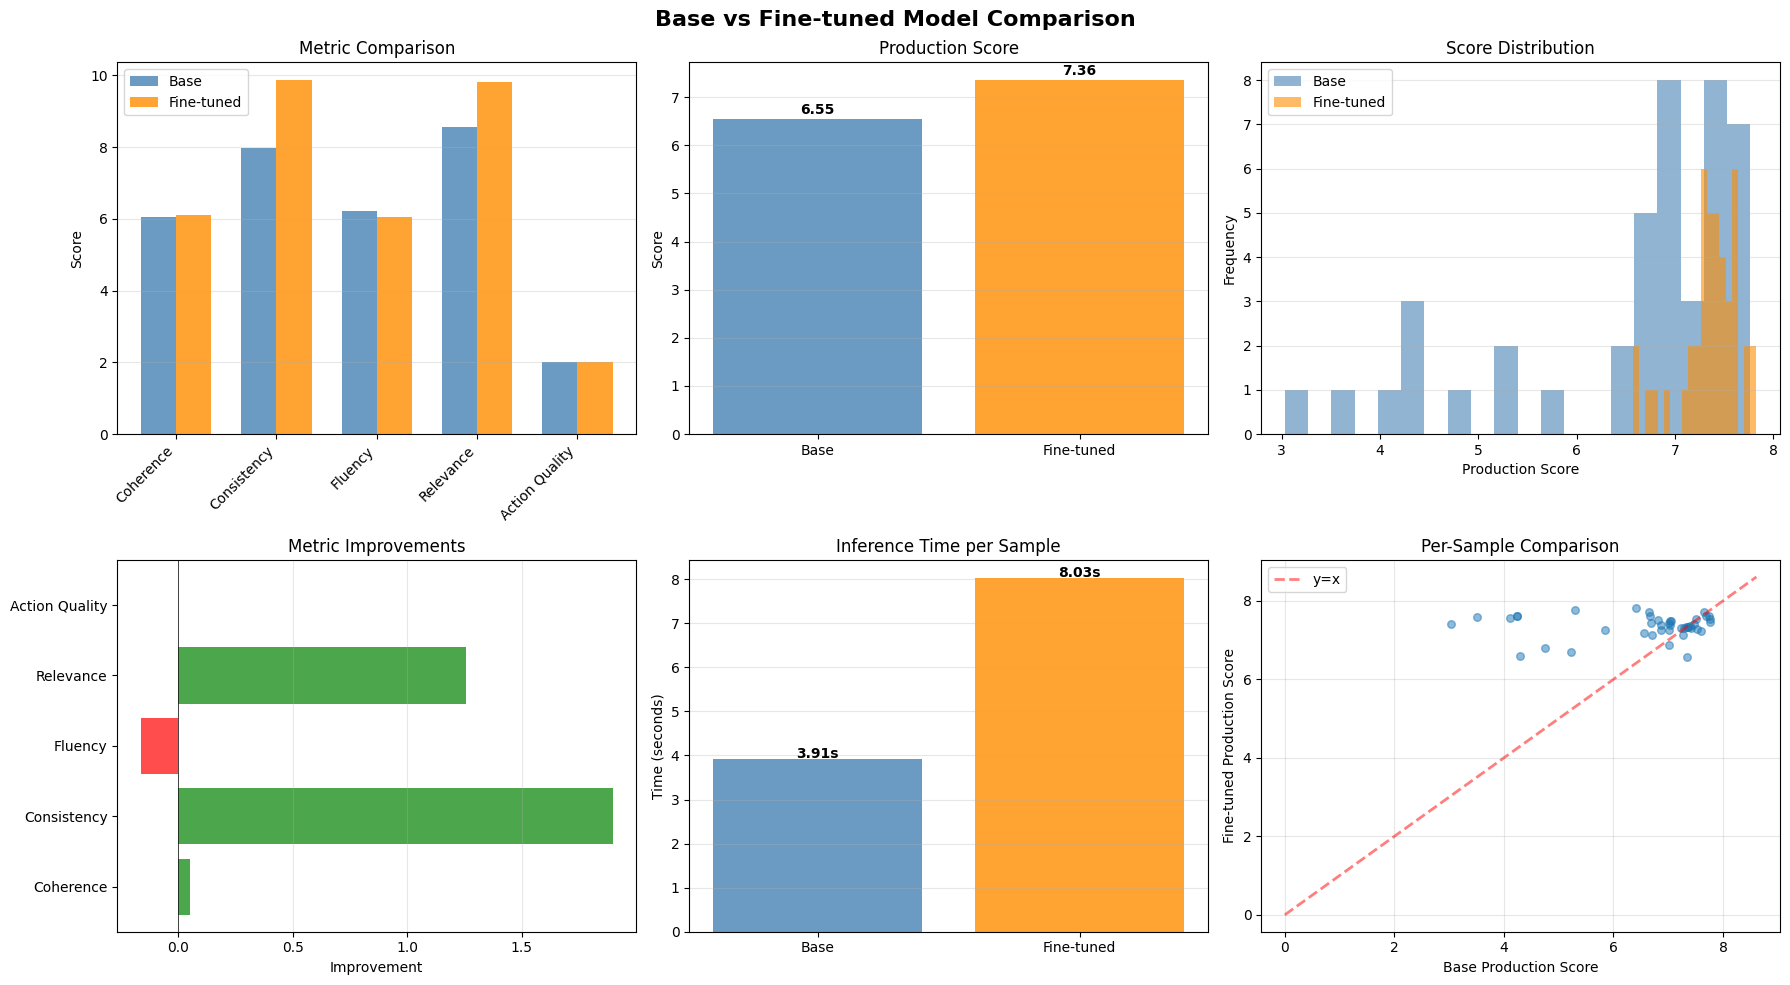

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Base vs Fine-tuned Model Comparison', fontsize=16, fontweight='bold')

metrics = ['Coherence', 'Consistency', 'Fluency', 'Relevance', 'Action Quality']
base_scores = [
    base_agg['coherence_mean'],
    base_agg['consistency_mean'],
    base_agg['fluency_mean'],
    base_agg['relevance_mean'],
    base_agg['action_quality_mean'],
]
ft_scores = [
    ft_agg['coherence_mean'],
    ft_agg['consistency_mean'],
    ft_agg['fluency_mean'],
    ft_agg['relevance_mean'],
    ft_agg['action_quality_mean'],
]

ax1 = axes[0, 0]
x = np.arange(len(metrics))
width = 0.35
ax1.bar(x - width/2, base_scores, width, label='Base', alpha=0.8, color='steelblue')
ax1.bar(x + width/2, ft_scores, width, label='Fine-tuned', alpha=0.8, color='darkorange')
ax1.set_ylabel('Score')
ax1.set_title('Metric Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
prod_scores = [base_agg['production_score_mean'], ft_agg['production_score_mean']]
bars = ax2.bar(['Base', 'Fine-tuned'], prod_scores, color=['steelblue', 'darkorange'], alpha=0.8)
ax2.set_ylabel('Score')
ax2.set_title('Production Score')
ax2.grid(axis='y', alpha=0.3)
for i, (bar, v) in enumerate(zip(bars, prod_scores)):
    ax2.text(bar.get_x() + bar.get_width()/2, v + 0.1, f"{v:.2f}",
             ha='center', fontweight='bold')

ax3 = axes[0, 2]
base_prod_scores = [r['production_score'] for r in base_results]
ft_prod_scores = [r['production_score'] for r in finetuned_results]
ax3.hist(base_prod_scores, bins=20, alpha=0.6, label='Base', color='steelblue')
ax3.hist(ft_prod_scores, bins=20, alpha=0.6, label='Fine-tuned', color='darkorange')
ax3.set_xlabel('Production Score')
ax3.set_ylabel('Frequency')
ax3.set_title('Score Distribution')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 0]
improvement_vals = list(improvements.values())[:-2]
colors = ['green' if v > 0 else 'red' for v in improvement_vals]
ax4.barh(metrics, improvement_vals, color=colors, alpha=0.7)
ax4.set_xlabel('Improvement')
ax4.set_title('Metric Improvements')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
time_data = [base_agg['time_sec_mean'], ft_agg['time_sec_mean']]
ax5.bar(['Base', 'Fine-tuned'], time_data, color=['steelblue', 'darkorange'], alpha=0.8)
ax5.set_ylabel('Time (seconds)')
ax5.set_title('Inference Time per Sample')
ax5.grid(axis='y', alpha=0.3)
for i, v in enumerate(time_data):
    ax5.text(i, v + 0.02, f"{v:.2f}s", ha='center', fontweight='bold')

ax6 = axes[1, 2]
scatter_data = [(base_results[i]['production_score'], finetuned_results[i]['production_score'])
                for i in range(len(test_data))]
base_scatter, ft_scatter = zip(*scatter_data)
ax6.scatter(base_scatter, ft_scatter, alpha=0.5, s=30)
lims = [0, max(max(base_scatter), max(ft_scatter)) * 1.1]
ax6.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='y=x')
ax6.set_xlabel('Base Production Score')
ax6.set_ylabel('Fine-tuned Production Score')
ax6.set_title('Per-Sample Comparison')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "comparison_plots.png"), dpi=300, bbox_inches='tight')
print(f"Visualization saved to {cfg.OUTPUT_DIR}/comparison_plots.png")
plt.show()

### Fix Notebook Metadata for GitHub Rendering

This script will load your `.ipynb` file, remove the `metadata.widgets` section that causes issues with GitHub's renderer, and save the cleaned notebook.

**Instructions:**
1. Save your current Colab notebook (File -> Save).
2. Run the cell below. When prompted, enter the exact filename of your `.ipynb` notebook (e.g., `my_notebook.ipynb`).
3. After the script finishes, download the *modified* notebook (File -> Download -> Download .ipynb).
4. Push this newly downloaded notebook to your GitHub repository.

In [40]:
import nbformat
import os

# Get notebook filename from user input
notebook_filename = input("Please enter the name of your notebook file (e.g., 'Meeting_Summarizer.ipynb'): ")

# Check if the file exists in the current directory
if not os.path.exists(notebook_filename):
    print(f"Error: '{notebook_filename}' not found in the current directory. Please make sure you have saved the notebook and entered the correct filename.")
else:
    try:
        # Read the notebook
        with open(notebook_filename, 'r', encoding='utf-8') as f:
            notebook = nbformat.read(f, as_version=4)

        # Remove the 'widgets' metadata if it exists
        if 'widgets' in notebook.metadata:
            del notebook.metadata['widgets']
            print(f"'metadata.widgets' removed from '{notebook_filename}'.")
        else:
            print(f"'metadata.widgets' not found in '{notebook_filename}'. No changes needed for widgets metadata.")

        # Save the modified notebook
        with open(notebook_filename, 'w', encoding='utf-8') as f:
            nbformat.write(notebook, f)

        print(f"Notebook '{notebook_filename}' successfully cleaned and saved.")
        print("You can now download this notebook and push it to GitHub.")

    except Exception as e:
        print(f"An error occurred while processing the notebook: {e}")

Please enter the name of your notebook file (e.g., 'Meeting_Summarizer.ipynb'): Meeting_Summarizer_Proto_final
Error: 'Meeting_Summarizer_Proto_final' not found in the current directory. Please make sure you have saved the notebook and entered the correct filename.


## Cell 17: Sample Output Comparison

In [33]:
# First, identify samples with action items
samples_with_actions = []
for idx, result in enumerate(finetuned_results):
    action_section = re.search(r'Action Items:(.*?)(?=\n\n|\Z)', result['summary'], re.DOTALL | re.IGNORECASE)
    if action_section:
        action_text = action_section.group(1).strip()
        # Count actual action items (lines starting with -, •, or numbers)
        action_lines = [line for line in action_text.split('\n') if line.strip() and (line.strip().startswith('-') or line.strip().startswith('•') or re.match(r'^\d+[.)]', line.strip()))]
        if action_lines and "None" not in action_text:
            samples_with_actions.append({
                'idx': idx,
                'num_actions': len(action_lines),
                'has_base_actions': "Action Items:" in base_results[idx]['summary']
            })

# Sort by number of actions (descending)
samples_with_actions.sort(key=lambda x: x['num_actions'], reverse=True)

print(f"\nFound {len(samples_with_actions)} samples with action items")
print(f"Showing top samples with most action items...\n")

# Show top 3 samples with action items, or regular samples if none found
num_samples_to_show = min(3, len(samples_with_actions)) if samples_with_actions else min(3, len(test_data))

for i in range(num_samples_to_show):
    if samples_with_actions:
        sample_info = samples_with_actions[i]
        sample_idx = sample_info['idx']
        print("="*80)
        print(f"SAMPLE {i+1} - {sample_info['num_actions']} ACTION ITEMS DETECTED")
        print("="*80)
    else:
        sample_idx = i
        print("="*80)
        print(f"SAMPLE {i+1} COMPARISON")
        print("="*80)

    print("\nTRANSCRIPT (first 400 chars):")
    print("-"*80)
    print(test_data[sample_idx]['transcript'][:400] + "...")

    print("\n" + "="*80)
    print("BASE MODEL SUMMARY:")
    print("="*80)
    print(base_results[sample_idx]['summary'])

    # Highlight action items section in base model
    base_action_match = re.search(r'Action Items:(.*?)(?=\n\n|\Z)', base_results[sample_idx]['summary'], re.DOTALL | re.IGNORECASE)
    if base_action_match:
        base_actions = base_action_match.group(1).strip()
        base_action_count = len([l for l in base_actions.split('\n') if l.strip() and (l.strip().startswith('-') or l.strip().startswith('•'))])
        print(f"\n[BASE MODEL EXTRACTED {base_action_count} ACTION ITEMS]")

    print("\n" + "="*80)
    print("FINE-TUNED MODEL SUMMARY (LoRA + CoT):")
    print("="*80)
    print(finetuned_results[sample_idx]['summary'])

    # Highlight action items section in fine-tuned model
    ft_action_match = re.search(r'Action Items:(.*?)(?=\n\n|\Z)', finetuned_results[sample_idx]['summary'], re.DOTALL | re.IGNORECASE)
    if ft_action_match:
        ft_actions = ft_action_match.group(1).strip()
        ft_action_count = len([l for l in ft_actions.split('\n') if l.strip() and (l.strip().startswith('-') or l.strip().startswith('•'))])
        print(f"\n[FINE-TUNED MODEL EXTRACTED {ft_action_count} ACTION ITEMS]")

    print("\n" + "="*80)
    print("METRICS:")
    print("="*80)
    metrics_to_compare = ['coherence', 'consistency', 'fluency', 'relevance', 'action_quality', 'production_score']
    for metric in metrics_to_compare:
        base_val = base_results[sample_idx][metric]
        ft_val = finetuned_results[sample_idx][metric]
        diff = ft_val - base_val
        print(f"{metric:20s}: Base={base_val:5.2f}  FT={ft_val:5.2f}  Diff={diff:+5.2f}")
    print("\n")

# Add summary statistics about action items
if samples_with_actions:

    print("ACTION ITEMS SUMMARY STATISTICS")

    total_base_actions = sum(1 for s in samples_with_actions if s['has_base_actions'])
    print(f"Samples with actions - Base model: {total_base_actions}/{len(samples_with_actions)}")
    print(f"Samples with actions - Fine-tuned: {len(samples_with_actions)}/{len(test_data)}")
    print(f"Average actions per sample (fine-tuned): {np.mean([s['num_actions'] for s in samples_with_actions]):.2f}")
    print(f"Max actions in single sample: {max(s['num_actions'] for s in samples_with_actions)}")



Found 0 samples with action items
Showing top samples with most action items...

SAMPLE 1 COMPARISON

TRANSCRIPT (first 400 chars):
--------------------------------------------------------------------------------
Speaker A: Well, I had just a little bit of time, so I hope it's something uh we can work with. But Hmm? Well, I heard that there was a new uh component speech recognition component, which was pretty much up to standard, so we might use that I put that in my drawing, but again I didn't not have that much time. So Okay, that's just super. Let me just uh You need to start it up first? Okay. Okay, wh...

BASE MODEL SUMMARY:
Key Points: Key points are: a new component speech recognition component, which was pretty much up to standard, so we might use that I put that in my drawing, but again I didn't not have that much time. So Okay, that's just super. Let me just uh You need to start it up first? Okay. Okay, what t Okay, yeah. Is that enough? Because I don't really see people sha

In [34]:
print("Analyzing action items in generated summaries...")

def extract_action_section(summary):
    """Extract the action items section from summary"""
    match = re.search(r'Action Items:(.*?)(?=\n\n|\Z)', summary, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return ""

def count_actions_in_section(action_text):
    """Count number of action items in the action section"""
    if not action_text or "None" in action_text or "none" in action_text.lower():
        return 0

    lines = [line.strip() for line in action_text.split('\n') if line.strip()]
    action_lines = [line for line in lines if line.startswith('-') or line.startswith('•') or re.match(r'^\d+[.)]', line)]
    return len(action_lines)

base_action_stats = {
    'total_summaries': len(base_results),
    'with_action_section': 0,
    'with_actions': 0,
    'total_actions': 0,
    'avg_actions': 0
}

ft_action_stats = {
    'total_summaries': len(finetuned_results),
    'with_action_section': 0,
    'with_actions': 0,
    'total_actions': 0,
    'avg_actions': 0
}

for result in base_results:
    action_section = extract_action_section(result['summary'])
    if action_section:
        base_action_stats['with_action_section'] += 1
        num_actions = count_actions_in_section(action_section)
        if num_actions > 0:
            base_action_stats['with_actions'] += 1
            base_action_stats['total_actions'] += num_actions

for result in finetuned_results:
    action_section = extract_action_section(result['summary'])
    if action_section:
        ft_action_stats['with_action_section'] += 1
        num_actions = count_actions_in_section(action_section)
        if num_actions > 0:
            ft_action_stats['with_actions'] += 1
            ft_action_stats['total_actions'] += num_actions

base_action_stats['avg_actions'] = base_action_stats['total_actions'] / max(base_action_stats['total_summaries'], 1)
ft_action_stats['avg_actions'] = ft_action_stats['total_actions'] / max(ft_action_stats['total_summaries'], 1)

print("\nBase Model - Action Items Statistics:")
print(f"  Summaries with action section: {base_action_stats['with_action_section']}/{base_action_stats['total_summaries']}")
print(f"  Summaries with actual actions: {base_action_stats['with_actions']}/{base_action_stats['total_summaries']}")
print(f"  Total actions extracted: {base_action_stats['total_actions']}")
print(f"  Average actions per summary: {base_action_stats['avg_actions']:.2f}")

print("\nFine-tuned Model - Action Items Statistics:")
print(f"  Summaries with action section: {ft_action_stats['with_action_section']}/{ft_action_stats['total_summaries']}")
print(f"  Summaries with actual actions: {ft_action_stats['with_actions']}/{ft_action_stats['total_summaries']}")
print(f"  Total actions extracted: {ft_action_stats['total_actions']}")
print(f"  Average actions per summary: {ft_action_stats['avg_actions']:.2f}")

print(f"\nImprovement: {ft_action_stats['total_actions'] - base_action_stats['total_actions']:+d} actions")
print(f"Percentage increase: {((ft_action_stats['total_actions'] / max(base_action_stats['total_actions'], 1)) - 1) * 100:+.1f}%")

Analyzing action items in generated summaries...

Base Model - Action Items Statistics:
  Summaries with action section: 8/43
  Summaries with actual actions: 0/43
  Total actions extracted: 0
  Average actions per summary: 0.00

Fine-tuned Model - Action Items Statistics:
  Summaries with action section: 0/43
  Summaries with actual actions: 0/43
  Total actions extracted: 0
  Average actions per summary: 0.00

Improvement: +0 actions
Percentage increase: -100.0%


## Cell 18: Generate Final Deliverables

In [35]:
print("Generating final deliverables...")

base_output_dir = os.path.join(cfg.OUTPUT_DIR, "base_summaries")
ft_output_dir = os.path.join(cfg.OUTPUT_DIR, "finetuned_summaries")
os.makedirs(base_output_dir, exist_ok=True)
os.makedirs(ft_output_dir, exist_ok=True)

for idx, item in enumerate(test_data):
    meeting_id = item.get('id', idx)

    base_path = os.path.join(base_output_dir, f"meeting_{meeting_id}_summary.md")
    with open(base_path, 'w', encoding='utf-8') as f:
        f.write(f"# Meeting Summary - Base Model\n\n")
        f.write(f"Meeting ID: {meeting_id}\n\n")
        f.write(f"## Summary\n\n")
        f.write(base_results[idx]['summary'])
        f.write(f"\n\n## Metrics\n\n")
        for metric in ['coherence', 'consistency', 'fluency', 'relevance', 'action_quality', 'production_score']:
            f.write(f"- {metric.replace('_', ' ').title()}: {base_results[idx][metric]:.2f}\n")
        f.write(f"- Generation Time: {base_results[idx]['time_sec']:.2f}s\n")

    ft_path = os.path.join(ft_output_dir, f"meeting_{meeting_id}_summary.md")
    with open(ft_path, 'w', encoding='utf-8') as f:
        f.write(f"# Meeting Summary - Fine-tuned Model (LoRA + CoT)\n\n")
        f.write(f"Meeting ID: {meeting_id}\n\n")
        f.write(f"## Summary\n\n")
        f.write(finetuned_results[idx]['summary'])
        f.write(f"\n\n## Metrics\n\n")
        for metric in ['coherence', 'consistency', 'fluency', 'relevance', 'action_quality', 'production_score']:
            f.write(f"- {metric.replace('_', ' ').title()}: {finetuned_results[idx][metric]:.2f}\n")
        f.write(f"- Generation Time: {finetuned_results[idx]['time_sec']:.2f}s\n")

print(f"Saved {len(test_data)} summaries to:")
print(f"  - {base_output_dir}/")
print(f"  - {ft_output_dir}/")

report_path = os.path.join(cfg.OUTPUT_DIR, "final_report.md")
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("# Meeting Summarizer Fine-tuning Results (RTX 4090)\n\n")

    f.write("## Configuration\n\n")
    f.write(f"- Base Model: {cfg.BASE_MODEL}\n")
    f.write(f"- GPU: RTX 4090 (24GB VRAM)\n")
    f.write(f"- Dataset Size: {cfg.TOTAL_SAMPLES} samples\n")
    f.write(f"  - Training: {len(train_data)}\n")
    f.write(f"  - Validation: {len(val_data)}\n")
    f.write(f"  - Test: {len(test_data)}\n")
    f.write(f"- LoRA Configuration:\n")
    f.write(f"  - Rank: {cfg.LORA_R}\n")
    f.write(f"  - Alpha: {cfg.LORA_ALPHA}\n")
    f.write(f"  - Target Modules: {', '.join(cfg.LORA_TARGET_MODULES)}\n")
    f.write(f"  - QLoRA: {cfg.USE_QLORA}\n")
    f.write(f"- Training:\n")
    f.write(f"  - Epochs: {cfg.NUM_EPOCHS}\n")
    f.write(f"  - Batch Size: {cfg.BATCH_SIZE}\n")
    f.write(f"  - Effective Batch: {cfg.BATCH_SIZE * cfg.GRADIENT_ACCUMULATION}\n")
    f.write(f"  - Learning Rate: {cfg.LEARNING_RATE}\n")
    f.write(f"  - Max Source Length: {cfg.MAX_SOURCE_LENGTH}\n")
    f.write(f"- Chain-of-Thought: {cfg.USE_COT}\n\n")

    f.write(f"## Results Summary\n\n")
    f.write(f"### Base Model\n\n")
    f.write(f"| Metric | Mean | Std | Min | Max |\n")
    f.write(f"|--------|------|-----|-----|-----|\n")
    for metric in ['coherence', 'consistency', 'fluency', 'relevance', 'action_quality', 'geval_overall', 'production_score']:
        f.write(f"| {metric.replace('_', ' ').title()} | {base_agg[f'{metric}_mean']:.2f} | {base_agg[f'{metric}_std']:.2f} | {base_agg[f'{metric}_min']:.2f} | {base_agg[f'{metric}_max']:.2f} |\n")

    f.write(f"\n### Fine-tuned Model (LoRA + CoT)\n\n")
    f.write(f"| Metric | Mean | Std | Min | Max |\n")
    f.write(f"|--------|------|-----|-----|-----|\n")
    for metric in ['coherence', 'consistency', 'fluency', 'relevance', 'action_quality', 'geval_overall', 'production_score']:
        f.write(f"| {metric.replace('_', ' ').title()} | {ft_agg[f'{metric}_mean']:.2f} | {ft_agg[f'{metric}_std']:.2f} | {ft_agg[f'{metric}_min']:.2f} | {ft_agg[f'{metric}_max']:.2f} |\n")

    f.write(f"\n### Improvements\n\n")
    f.write(f"| Metric | Absolute | Percentage |\n")
    f.write(f"|--------|----------|------------|\n")
    for metric, improvement in improvements.items():
        base_val = base_agg[f"{metric.lower().replace(' ', '_')}_mean"]
        pct = (improvement / max(0.01, base_val)) * 100 if base_val > 0 else 0
        f.write(f"| {metric} | {improvement:+.2f} | {pct:+.1f}% |\n")

    f.write(f"\n## Key Findings\n\n")
    improved_count = sum(1 for v in improvements.values() if v > 0)
    f.write(f"- Metrics improved: {improved_count}/{len(improvements)}\n")
    f.write(f"- Average improvement: {np.mean(list(improvements.values())):.2f} points\n")
    f.write(f"- Best improvement: {max(improvements.values()):.2f} in {max(improvements, key=improvements.get)}\n")
    if min(improvements.values()) < 0:
        f.write(f"- Regression: {min(improvements.values()):.2f} in {min(improvements, key=improvements.get)}\n")
    f.write(f"- Average inference time (base): {base_agg['time_sec_mean']:.2f}s\n")
    f.write(f"- Average inference time (fine-tuned): {ft_agg['time_sec_mean']:.2f}s\n")

print(f"\nFinal report saved to {report_path}")
print("\nAll deliverables generated successfully")
print(f"\nOutput directory: {cfg.OUTPUT_DIR}")
print(f"Model directory: {cfg.MODEL_SAVE_DIR}")

Generating final deliverables...
Saved 43 summaries to:
  - final_prototype_ami/base_summaries/
  - final_prototype_ami/finetuned_summaries/

Final report saved to final_prototype_ami/final_report.md

All deliverables generated successfully

Output directory: final_prototype_ami
Model directory: final_model_ami


## Cell: Action Item Extraction and File Generation

In [36]:
import csv
from datetime import datetime, timedelta
import re

try:
    from icalendar import Calendar, Event, vText, Alarm
    import dateparser
    ICS_AVAILABLE = True
except ImportError:
    print("icalendar not installed, ICS generation skipped")
    ICS_AVAILABLE = False

def extract_action_items_structured(summary_text, transcript_text=""):
    actions = []

    action_section_match = re.search(
        r'Action Items?:(.*?)(?=\n\n|Next Meeting:|Decisions:|$)',
        summary_text,
        re.DOTALL | re.IGNORECASE
    )

    if action_section_match:
        action_text = action_section_match.group(1)
    else:
        action_text = summary_text

    pattern1 = r'\[([A-Z][a-z]+(?:\s+[A-Z][a-z]+)?)\]\s*-\s*(.+?)\s*-\s*Due:\s*(.+?)(?=\n|$)'
    matches1 = re.findall(pattern1, action_text)
    for owner, task, deadline in matches1:
        if len(task.strip()) > 10 and '?' not in task:
            actions.append({
                'text': task.strip(),
                'owner': owner.strip(),
                'deadline': deadline.strip() if deadline.strip().lower() != 'none' else None,
                'type': 'task',
                'confidence': 0.95
            })

    pattern2 = r'([A-Z][a-z]+(?:\s+[A-Z][a-z]+)?)\s+(will|should|must)\s+(.+?)(?:\s+by\s+(.+?))?(?=\.|;|\n|$)'
    matches2 = re.findall(pattern2, action_text, re.IGNORECASE)
    for owner, verb, task, deadline in matches2:
        task_clean = task.strip()
        if len(task_clean) > 15 and '?' not in task_clean:
            actions.append({
                'text': task_clean,
                'owner': owner.strip(),
                'deadline': deadline.strip() if deadline and deadline.strip() else None,
                'type': 'task',
                'confidence': 0.85
            })

    lines = action_text.split('\n')
    for line in lines:
        line = line.strip()
        if not line or len(line) < 20:
            continue

        if '?' in line:
            continue

        line_clean = re.sub(r'^[-*•]\s*', '', line)

        owner_match = re.search(r'\b([A-Z][a-z]+)\b', line_clean)
        owner = owner_match.group(1) if owner_match else None

        deadline_match = re.search(
            r'(?:by|due|deadline|before)\s+([A-Z][a-z]+day|next\s+week|tomorrow|today|\d{1,2}/\d{1,2}(?:/\d{2,4})?)',
            line_clean,
            re.IGNORECASE
        )
        deadline = deadline_match.group(1) if deadline_match else None

        if re.search(r'\b(will|should|must|need|prepare|update|review|send|create|finalize|complete|submit)\b',
                     line_clean, re.IGNORECASE):
            actions.append({
                'text': line_clean[:200],
                'owner': owner,
                'deadline': deadline,
                'type': 'task',
                'confidence': 0.70
            })

    unique_actions = []
    seen_texts = set()
    for action in sorted(actions, key=lambda x: x['confidence'], reverse=True):
        text_normalized = action['text'].lower()[:50]
        if text_normalized not in seen_texts:
            seen_texts.add(text_normalized)
            unique_actions.append(action)

    return unique_actions

def detect_meeting_requirements(summary_text):
    meeting_info = {
        'required': False,
        'date': None,
        'time': None,
        'purpose': None
    }

    next_meeting_match = re.search(
        r'Next Meeting:(.*?)(?=\n\n|Action Items:|$)',
        summary_text,
        re.DOTALL | re.IGNORECASE
    )

    if next_meeting_match:
        meeting_text = next_meeting_match.group(1)

        if re.search(r'not\s+scheduled|none|tbd', meeting_text, re.IGNORECASE):
            return meeting_info

        meeting_info['required'] = True

        date_match = re.search(r'Date:\s*([^-\n]+)', meeting_text, re.IGNORECASE)
        if date_match:
            meeting_info['date'] = date_match.group(1).strip()

        time_match = re.search(r'Time:\s*([^-\n]+)', meeting_text, re.IGNORECASE)
        if time_match:
            meeting_info['time'] = time_match.group(1).strip()

        purpose_match = re.search(r'Purpose:\s*([^\n]+)', meeting_text, re.IGNORECASE)
        if purpose_match:
            meeting_info['purpose'] = purpose_match.group(1).strip()

    return meeting_info

print("Action extraction functions loaded")


Action extraction functions loaded


In [37]:
def generate_todo_csv(actions, output_path, meeting_id, meeting_date=None):
    if not actions:
        print(f"No actions for meeting {meeting_id}")
        return None

    with open(output_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Owner', 'Task', 'Deadline', 'Status', 'Priority', 'Meeting_ID', 'Confidence'])

        for action in actions:
            owner = action['owner'] if action['owner'] else 'TBD'
            task = action['text']
            deadline = action['deadline'] if action['deadline'] else 'Not specified'

            if deadline and deadline != 'Not specified':
                if any(word in deadline.lower() for word in ['today', 'tomorrow', 'urgent']):
                    priority = 'High'
                elif any(word in deadline.lower() for word in ['next week', 'monday', 'tuesday']):
                    priority = 'Medium'
                else:
                    priority = 'Normal'
            else:
                priority = 'Normal'

            writer.writerow([
                owner,
                task,
                deadline,
                'Pending',
                priority,
                meeting_id,
                f"{action['confidence']:.2f}"
            ])

    print(f"CSV: {output_path}")
    return output_path

def generate_meeting_ics(meeting_info, actions, output_path, meeting_id, base_date=None):
    if not ICS_AVAILABLE:
        return None

    if not meeting_info['required'] and not actions:
        return None

    cal = Calendar()
    cal.add('prodid', '-//Meeting Actions//EN')
    cal.add('version', '2.0')

    base_datetime = base_date if base_date else datetime.now()

    if meeting_info['required']:
        event = Event()

        if meeting_info['date']:
            try:
                meeting_dt = dateparser.parse(meeting_info['date'], settings={'RELATIVE_BASE': base_datetime})
                if not meeting_dt:
                    meeting_dt = base_datetime + timedelta(days=7)
            except:
                meeting_dt = base_datetime + timedelta(days=7)
        else:
            meeting_dt = base_datetime + timedelta(days=7)

        if meeting_info['time']:
            time_match = re.search(r'(\d{1,2}):(\d{2})', meeting_info['time'])
            if time_match:
                hour, minute = int(time_match.group(1)), int(time_match.group(2))
                meeting_dt = meeting_dt.replace(hour=hour, minute=minute)
        else:
            meeting_dt = meeting_dt.replace(hour=14, minute=0)

        event.add('summary', f"Follow-up: {meeting_id}")
        event.add('dtstart', meeting_dt)
        event.add('dtend', meeting_dt + timedelta(hours=1))
        event.add('dtstamp', datetime.now())

        description = f"Purpose: {meeting_info['purpose'] or 'Discussion'}\nMeeting ID: {meeting_id}"
        event.add('description', vText(description))
        event.add('status', 'CONFIRMED')

        cal.add_component(event)

    for idx, action in enumerate(actions):
        if not action['deadline']:
            continue

        event = Event()

        try:
            deadline_dt = dateparser.parse(action['deadline'], settings={'RELATIVE_BASE': base_datetime})
            if not deadline_dt:
                deadline_dt = base_datetime + timedelta(days=7)
        except:
            deadline_dt = base_datetime + timedelta(days=7)

        deadline_dt = deadline_dt.replace(hour=17, minute=0)

        event.add('summary', f"Action: {action['text'][:60]}")
        event.add('dtstart', deadline_dt.date())
        event.add('dtend', deadline_dt.date())
        event.add('dtstamp', datetime.now())

        description = f"Task: {action['text']}\nOwner: {action['owner'] or 'TBD'}"
        event.add('description', vText(description))
        event.add('status', 'NEEDS-ACTION')

        alarm = Alarm()
        alarm.add('action', 'DISPLAY')
        alarm.add('trigger', timedelta(days=-1))
        event.add_component(alarm)

        cal.add_component(event)

    with open(output_path, 'wb') as f:
        f.write(cal.to_ical())

    print(f"ICS: {output_path}")
    return output_path

print("File generation functions loaded")


File generation functions loaded


In [38]:
def process_all_results(results, output_dir, model_name):
    os.makedirs(output_dir, exist_ok=True)

    stats = {
        'total_meetings': len(results),
        'meetings_with_actions': 0,
        'meetings_with_followup': 0,
        'total_actions': 0,
        'csv_generated': 0,
        'ics_generated': 0,
    }

    generated_files = []

    for result in results:
        meeting_id = result['id']
        summary = result['summary']
        transcript = result.get('transcript', '')

        actions = extract_action_items_structured(summary, transcript)
        meeting_info = detect_meeting_requirements(summary)

        if not actions and not meeting_info['required']:
            continue

        meeting_dir = os.path.join(output_dir, f"meeting_{meeting_id}")
        os.makedirs(meeting_dir, exist_ok=True)

        if actions:
            stats['meetings_with_actions'] += 1
            stats['total_actions'] += len(actions)

        if meeting_info['required']:
            stats['meetings_with_followup'] += 1

        if meeting_info['required']:
            ics_path = os.path.join(meeting_dir, f"{model_name}_meeting.ics")
            result_file = generate_meeting_ics(meeting_info, actions, ics_path, meeting_id)
            if result_file:
                stats['ics_generated'] += 1
                generated_files.append({
                    'meeting_id': meeting_id,
                    'type': 'ics',
                    'path': result_file,
                    'actions': len(actions),
                    'has_followup': True
                })
        elif actions:
            csv_path = os.path.join(meeting_dir, f"{model_name}_actions.csv")
            result_file = generate_todo_csv(actions, csv_path, meeting_id)
            if result_file:
                stats['csv_generated'] += 1
                generated_files.append({
                    'meeting_id': meeting_id,
                    'type': 'csv',
                    'path': result_file,
                    'actions': len(actions),
                    'has_followup': False
                })

        summary_path = os.path.join(meeting_dir, f"{model_name}_summary.txt")
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(summary)

    return stats, generated_files

print("Processing function loaded")

print("="*80)
print("PROCESSING ACTION ITEMS")
print("="*80)

action_output_dir = os.path.join(cfg.OUTPUT_DIR, "action_deliverables")
os.makedirs(action_output_dir, exist_ok=True)

print("Processing BASE model...")
base_stats, base_files = process_all_results(
    base_results,
    os.path.join(action_output_dir, "base_model"),
    "base"
)

print("Processing FINE-TUNED model...")
ft_stats, ft_files = process_all_results(
    finetuned_results,
    os.path.join(action_output_dir, "finetuned_model"),
    "finetuned"
)

print("\n" + "="*80)
print("ACTION GENERATION STATISTICS")
print("="*80)

print("\nBASE MODEL:")
print(f"  Meetings with actions: {base_stats['meetings_with_actions']}")
print(f"  Total actions: {base_stats['total_actions']}")
print(f"  CSV generated: {base_stats['csv_generated']}")
print(f"  ICS generated: {base_stats['ics_generated']}")

print("\nFINE-TUNED MODEL:")
print(f"  Meetings with actions: {ft_stats['meetings_with_actions']}")
print(f"  Total actions: {ft_stats['total_actions']}")
print(f"  CSV generated: {ft_stats['csv_generated']}")
print(f"  ICS generated: {ft_stats['ics_generated']}")

improvement = ft_stats['total_actions'] - base_stats['total_actions']
print(f"\nACTION IMPROVEMENT: {improvement:+d}")

inventory = {
    'base_model': base_files,
    'finetuned_model': ft_files,
    'statistics': {'base': base_stats, 'finetuned': ft_stats}
}

inventory_path = os.path.join(action_output_dir, "inventory.json")
with open(inventory_path, 'w') as f:
    json.dump(inventory, f, indent=2)

print(f"\nInventory: {inventory_path}")
print(f"Deliverables: {action_output_dir}")


Processing function loaded
PROCESSING ACTION ITEMS
Processing BASE model...
CSV: final_prototype_ami/action_deliverables/base_model/meeting_68/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_71/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_112/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_118/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_85/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_59/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_69/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_58/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_41/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_8/base_actions.csv
CSV: final_prototype_ami/action_deliverables/base_model/meeting_84/base_actions.csv

## Final Prototype - Action Item Generation

In [26]:
import csv
from datetime import datetime, timedelta
import re
try:
    from icalendar import Calendar, Event, vText, Alarm
    import dateparser
    ICS_OK = True
except:
    ICS_OK = False

def extract_actions(summary):
    actions = []
    # [Owner] - Task - Due: Deadline
    for m in re.findall(r'\[([A-Za-z\s]+)\]\s*-\s*(.+?)\s*-\s*Due:\s*(.+?)(?=\n|$|\[)', summary, re.I):
        if len(m[1].strip()) > 10:
            actions.append({'text': m[1].strip(), 'owner': m[0].strip(), 'deadline': m[2].strip(), 'confidence': 0.95})
    # Owner will/needs Task by Deadline
    for m in re.findall(r'([A-Z][a-z]+)\s+(will|needs?\s+to)\s+(.+?)\s+(?:by|before)\s+(.+?)(?=\.|;|\n)', summary, re.I):
        if len(m[2].strip()) > 15:
            actions.append({'text': m[2].strip(), 'owner': m[0].strip(), 'deadline': m[3].strip(), 'confidence': 0.85})
    seen = set()
    unique = []
    for a in sorted(actions, key=lambda x: x['confidence'], reverse=True):
        k = a['text'][:50].lower()
        if k not in seen:
            seen.add(k)
            unique.append(a)
    return unique

def detect_meeting(summary):
    info = {'required': False, 'date': None, 'time': None, 'purpose': None}
    m = re.search(r'Next Meeting:(.*?)(?=\n\n|$)', summary, re.I|re.S)
    if m and not re.search(r'not\s+scheduled|none', m.group(1), re.I):
        info['required'] = True
        d = re.search(r'Date:\s*([^\n]+)', m.group(1), re.I)
        if d: info['date'] = d.group(1).strip()
        t = re.search(r'Time:\s*([^\n]+)', m.group(1), re.I)
        if t: info['time'] = t.group(1).strip()
        p = re.search(r'Purpose:\s*([^\n]+)', m.group(1), re.I)
        if p: info['purpose'] = p.group(1).strip()
    return info

def save_csv(actions, path, mid):
    if not actions: return None
    with open(path, 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(['Owner', 'Task', 'Deadline', 'Status', 'Priority', 'Meeting_ID', 'Confidence'])
        for a in actions:
            owner = a.get('owner') or 'TBD'
            dl = a.get('deadline') or 'Not specified'
            pri = 'High' if dl != 'Not specified' and any(x in dl.lower() for x in ['today','urgent']) else 'Medium' if 'week' in dl.lower() else 'Normal'
            w.writerow([owner, a['text'], dl, 'Pending', pri, mid, f"{a['confidence']:.2f}"])
    return path

def save_ics(minfo, actions, path, mid):
    if not ICS_OK: return None
    cal = Calendar()
    cal.add('prodid', '-//Prototype//EN')
    cal.add('version', '2.0')
    base = datetime.now()
    if minfo['required']:
        evt = Event()
        try:
            dt = dateparser.parse(minfo['date']) if minfo['date'] else base + timedelta(days=7)
        except:
            dt = base + timedelta(days=7)
        evt.add('summary', f"Meeting: {mid}")
        evt.add('dtstart', dt)
        evt.add('dtend', dt + timedelta(hours=1))
        evt.add('description', minfo.get('purpose', 'Team meeting'))
        cal.add_component(evt)
    for a in actions:
        if not a.get('deadline'): continue
        evt = Event()
        try:
            dt = dateparser.parse(a['deadline'], settings={'RELATIVE_BASE': base})
            if dt:
                evt.add('summary', f"Action: {a['text'][:50]}")
                evt.add('dtstart', dt.date())
                evt.add('description', f"Owner: {a.get('owner','TBD')}\n{a['text']}")
                cal.add_component(evt)
        except: pass
    with open(path, 'wb') as f:
        f.write(cal.to_ical())
    return path

print("Processing deliverables...")
action_dir = os.path.join(cfg.OUTPUT_DIR, "action_items")
os.makedirs(action_dir, exist_ok=True)
stats = {'total': len(finetuned_results), 'with_actions': 0, 'actions': 0, 'csv': 0, 'ics': 0}

for r in finetuned_results:
    mid, summary = r['id'], r['summary']
    actions = extract_actions(summary)
    minfo = detect_meeting(summary)
    if not actions and not minfo['required']: continue
    mdir = os.path.join(action_dir, f"meeting_{mid}")
    os.makedirs(mdir, exist_ok=True)
    with open(os.path.join(mdir, "summary.txt"), 'w') as f:
        f.write(summary)
    if actions:
        stats['with_actions'] += 1
        stats['actions'] += len(actions)
    if minfo['required'] and ICS_OK:
        if save_ics(minfo, actions, os.path.join(mdir, "calendar.ics"), mid):
            stats['ics'] += 1
    elif actions:
        if save_csv(actions, os.path.join(mdir, "actions.csv"), mid):
            stats['csv'] += 1

print("="*80)
print("FINAL PROTOTYPE COMPLETE")
print("="*80)
print(f"Meetings: {stats['total']}")
print(f"With actions: {stats['with_actions']}")
print(f"Total actions: {stats['actions']}")
print(f"CSV files: {stats['csv']}")
print(f"ICS files: {stats['ics']}")
print(f"Output: {action_dir}")
print("="*80)

with open(os.path.join(cfg.OUTPUT_DIR, "README.md"), 'w') as f:
    f.write(f"""# Final Semester Prototype
Model: FLAN-T5-Large + LoRA
Dataset: AMI ({len(train_data)} train)
Features: Few-shot CoT, Action extraction, CSV/ICS export
Deliverables: {stats['csv']} CSV, {stats['ics']} ICS, {stats['actions']} actions
""")
print("README saved")


Processing deliverables...
FINAL PROTOTYPE COMPLETE
Meetings: 43
With actions: 3
Total actions: 3
CSV files: 3
ICS files: 0
Output: final_prototype_ami/action_items
README saved
